In [8]:
import os
print(os.listdir("/home/mh/Documents/NLU-exe/xlm_roberta/xlm-roberta-base"))

['config .json', 'config.json', 'tokenizer.json', '.git', 'tokenizer_config.json', '.gitattributes', 'README.md', 'sentencepiece.bpe.model', 'pytorch_model.bin']


## split test dataset 

In [11]:
# Split validation data into validation and test sets
from pathlib import Path
import random


def split_validation_data(validation_file, test_file, split_ratio=0.15, seed=42):
    """
    Split the validation data into a smaller validation set and a test set.
    """
    random.seed(seed)
    lines = Path(validation_file).read_text("utf-8").strip().splitlines()
    random.shuffle(lines)

    split_index = int(len(lines) * (1 - split_ratio))
    validation_lines = lines[:split_index]
    test_lines = lines[split_index:]

    # Save new validation and test sets
    Path(validation_file).write_text("\n".join(validation_lines), encoding="utf-8")
    Path(test_file).write_text("\n".join(test_lines), encoding="utf-8")
    print(f"Validation set reduced to {len(validation_lines)} lines.")
    print(f"Test set created with {len(test_lines)} lines.")

validation_file = "../validation.txt"
test_file = "../test.txt"
split_validation_data(validation_file, test_file, split_ratio=0.15)

Validation set reduced to 178 lines.
Test set created with 32 lines.


### XLM-Roberta model training for slot filling task

Validation set reduced to 178 lines.
Test set created with 32 lines.
Epoch 1/10
Train Loss: 1.7980
Validation - Precision: 0.7507, Recall: 0.7507, F1-Score: 0.7507, Accuracy: 0.7507
Epoch 2/10
Train Loss: 0.8932
Validation - Precision: 0.8410, Recall: 0.8410, F1-Score: 0.8410, Accuracy: 0.8410
Epoch 3/10
Train Loss: 0.4793
Validation - Precision: 0.9051, Recall: 0.9051, F1-Score: 0.9051, Accuracy: 0.9051
Epoch 4/10
Train Loss: 0.2842
Validation - Precision: 0.9380, Recall: 0.9380, F1-Score: 0.9380, Accuracy: 0.9380
Epoch 5/10
Train Loss: 0.1848
Validation - Precision: 0.9595, Recall: 0.9595, F1-Score: 0.9595, Accuracy: 0.9595
Epoch 6/10
Train Loss: 0.1208
Validation - Precision: 0.9728, Recall: 0.9728, F1-Score: 0.9728, Accuracy: 0.9728
Epoch 7/10
Train Loss: 0.0808
Validation - Precision: 0.9766, Recall: 0.9766, F1-Score: 0.9766, Accuracy: 0.9766
Epoch 8/10
Train Loss: 0.0680
Validation - Precision: 0.9750, Recall: 0.9750, F1-Score: 0.9750, Accuracy: 0.9750
No improvement in F1-score 

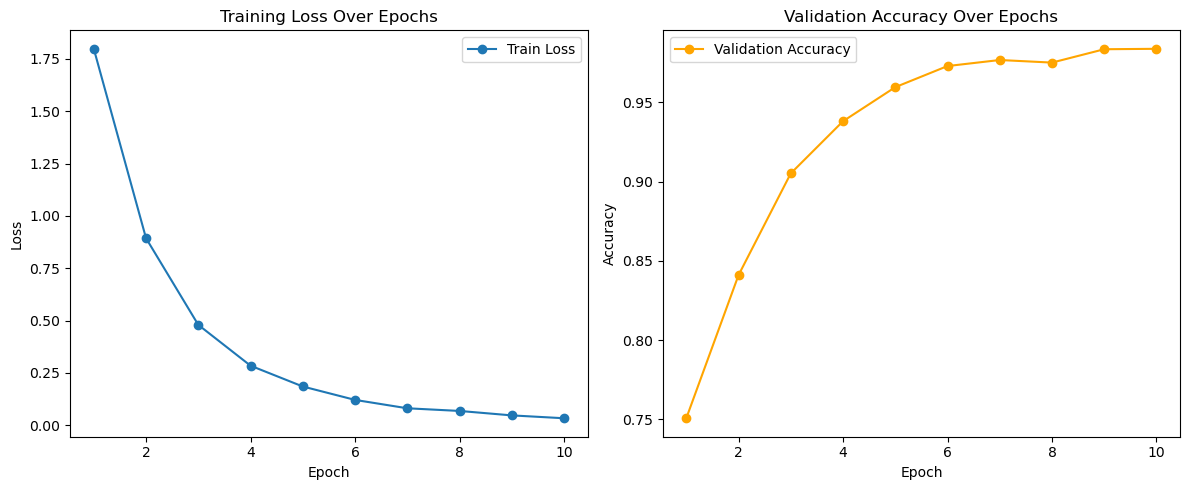

/tmp/ipykernel_43805/2584108583.py:303: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))



Test Set Evaluation:
Precision: 0.9777, Recall: 0.9777, F1-Score: 0.9777, Accuracy: 0.9777


In [2]:
import os
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from pathlib import Path


# Parse a single line of data
def parse_line(line):
    """
    Parse a single line from the dataset.
    """
    utterance_data, intent_label = line.split(" <=> ")
    items = utterance_data.split()
    words = []
    labels = []

    for item in items:
        split_item = item.rsplit(":", 1)
        if len(split_item) == 2:  # If there is a colon in the item
            words.append(split_item[0])
            labels.append(split_item[1])
        else:
            # If no colon, treat as 'O'
            words.append(item)
            labels.append('O')

    return {
        "intent_label": intent_label.strip(),
        "words": " ".join(words),
        "word_labels": " ".join(labels),
        "length": len(words),
    }

# Load data from a .txt file
def load_data(file_path):
    """
    Load and parse data from a .txt file.
    """
    lines = Path(file_path).read_text("utf-8").strip().splitlines()
    parsed = [parse_line(line) for line in lines]
    return pd.DataFrame([p for p in parsed if p is not None])

# Prepare data for tokenization and alignment
def prepare_data(df, tokenizer):
    sentences = df['words'].tolist()
    labels = df['word_labels'].apply(lambda x: x.split()).tolist()

    # Tokenization and alignment
    tokenized_data = []
    label_data = []

    for sentence, label in zip(sentences, labels):
        tokens = tokenizer(sentence.split(), is_split_into_words=True, truncation=True, padding='max_length', max_length=128)
        word_ids = tokens.word_ids()

        # Align labels with subwords
        aligned_labels = []
        prev_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)
            elif word_idx != prev_word_idx:
                aligned_labels.append(label_encoder.transform([label[word_idx]])[0])
            else:
                aligned_labels.append(-100)  # Ignore subwords
            prev_word_idx = word_idx

        tokenized_data.append({key: torch.tensor(val) for key, val in tokens.items()})
        label_data.append(torch.tensor(aligned_labels))

    return tokenized_data, label_data

# Dataset class
class SlotFillingDataset(Dataset):
    def __init__(self, tokenized_data, label_data):
        self.tokenized_data = tokenized_data
        self.label_data = label_data

    def __len__(self):
        return len(self.tokenized_data)

    def __getitem__(self, idx):
        tokens = self.tokenized_data[idx]
        labels = self.label_data[idx]

        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']

        return input_ids, attention_mask, labels

# Define the slot filling model
class SlotFillingModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(SlotFillingModel, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs.last_hidden_state)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))

        return logits, loss

# Training loop

import matplotlib.pyplot as plt
import numpy as np

def train(model, dataloader, optimizer, scheduler):
    """
    Training loop for one epoch.
    """
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()

        logits, loss = model(input_ids, attention_mask, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    """
    Evaluation loop to calculate metrics on validation or test data.
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            logits, _ = model(input_ids, attention_mask)
            predictions = torch.argmax(logits, dim=-1)

            for pred, label in zip(predictions, labels):
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(label.cpu().numpy())

    # Remove ignored indices (-100)
    valid_preds = [p for p, l in zip(all_preds, all_labels) if l != -100]
    valid_labels = [l for l in all_labels if l != -100]

    precision = precision_score(valid_labels, valid_preds, average='micro')
    recall = recall_score(valid_labels, valid_preds, average='micro')
    f1 = f1_score(valid_labels, valid_preds, average='micro')
    accuracy = accuracy_score(valid_labels, valid_preds)

    return precision, recall, f1, accuracy

def plot_metrics(train_losses, val_accuracies, num_epochs):
    """
    Plot training loss and validation accuracy over epochs.
    """
    epochs = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Define file paths
    train_file = "train.txt"
    validation_file = "validation.txt"
    test_file = "test.txt"

    # Load slot labels
    slot_labels_path = "slot.txt"
    with open(slot_labels_path, 'r') as f:
        SLOT_LABELS = [line.strip() for line in f.readlines()]

    # Define label encoder
    label_encoder = LabelEncoder()
    label_encoder.fit(SLOT_LABELS)

    # Load tokenizer
    MODEL_NAME = "/home/mh/Documents/NLU-exe/xlm_roberta/xlm-roberta-base"  # Use XLM-Roberta for Persian
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, add_prefix_space=True)

    # Load and prepare data
    df_train = load_data(train_file)
    df_valid = load_data(validation_file)
    df_test = load_data(test_file)

    train_tokens, train_labels = prepare_data(df_train, tokenizer)
    valid_tokens, valid_labels = prepare_data(df_valid, tokenizer)
    test_tokens, test_labels = prepare_data(df_test, tokenizer)

    train_dataset = SlotFillingDataset(train_tokens, train_labels)
    valid_dataset = SlotFillingDataset(valid_tokens, valid_labels)
    test_dataset = SlotFillingDataset(test_tokens, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Initialize model, optimizer, and scheduler
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = SlotFillingModel(MODEL_NAME, len(SLOT_LABELS)).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=10)

    # Early stopping parameters
    patience = 3  # Number of epochs to wait for improvement
    best_val_f1 = 0
    early_stop_counter = 0

    # Metrics tracking
    train_losses = []
    val_accuracies = []

    # Train model
    num_epochs = 10  # Increase the number of epochs to test early stopping
    for epoch in range(num_epochs):
        # Train for one epoch
        train_loss = train(model, train_loader, optimizer, scheduler)
        train_losses.append(train_loss)

        # Evaluate on validation set
        precision, recall, f1, accuracy = evaluate(model, valid_loader)
        val_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

        # Early stopping
        if f1 > best_val_f1:
            best_val_f1 = f1
            early_stop_counter = 0
            # Save the best model
            torch.save(model.state_dict(), "best_model.pth")
        else:
            early_stop_counter += 1
            print(f"No improvement in F1-score for {early_stop_counter} epoch(s).")

        if early_stop_counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

    # Plot training loss and validation accuracy
    plot_metrics(train_losses, val_accuracies, len(train_losses))

    # Load the best model for final evaluation
    model.load_state_dict(torch.load("best_model.pth"))

    # Evaluate on test set
    precision, recall, f1, accuracy = evaluate(model, test_loader)
    print("\nTest Set Evaluation:")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

## apply trained model on test dataset 

In [3]:
import torch
from transformers import AutoTokenizer
from pathlib import Path

def parse_test_line(line):
    """
    Parse a single line from the test.txt file.
    Extracts the words and removes the slot labels and intent.
    """
    utterance_data, _ = line.split(" <=> ")
    items = utterance_data.split()
    words = []

    for item in items:
        word, _ = item.rsplit(":", 1)  # Remove the slot label
        words.append(word)

    return " ".join(words)


def predict_slots(model, tokenizer, text, label_encoder):
    """
    Predict slot labels for a given text using the trained model.
    """
    # Tokenize the input text
    tokens = tokenizer(text.split(), is_split_into_words=True, truncation=True, padding='max_length', max_length=128, return_tensors="pt")
    word_ids = tokens.word_ids()

    # Move tensors to the same device as the model
    device = next(model.parameters()).device
    input_ids = tokens["input_ids"].to(device)
    attention_mask = tokens["attention_mask"].to(device)

    # Predict using the model
    model.eval()
    with torch.no_grad():
        logits, _ = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()

    # Align predictions back to words
    aligned_predictions = []
    prev_word_idx = None
    for word_idx, prediction in zip(word_ids, predictions):
        if word_idx is None or word_idx == prev_word_idx:
            continue  # Skip subwords or padding
        aligned_predictions.append(label_encoder.inverse_transform([prediction])[0])
        prev_word_idx = word_idx

    return aligned_predictions


def process_test_file(test_file, model, tokenizer, label_encoder):
    """
    Process the test.txt file, predict slot labels, and print the results.
    """
    # Read the test file
    lines = Path(test_file).read_text("utf-8").strip().splitlines()

    # Prepare for output
    plain_text_lines = []  # To save the plain text without slot labels
    results = []  # To store predictions for printing

    for line in lines:
        # Parse the line to get the plain text
        plain_text = parse_test_line(line)
        plain_text_lines.append(plain_text)

        # Predict slot labels
        predicted_slots = predict_slots(model, tokenizer, plain_text, label_encoder)

        # Prepare the aligned output
        words = plain_text.split()
        aligned_output = "\n".join([f"{word} -> {slot}" for word, slot in zip(words, predicted_slots)])
        results.append(f"Original Text:\n{plain_text}\n\nPredicted Slots:\n{aligned_output}\n{'-' * 50}")

    # Save the plain text back to test.txt
    Path(test_file).write_text("\n".join(plain_text_lines), encoding="utf-8")

    # Print the results
    print("\n\n".join(results))


if __name__ == "__main__":
    # Define file paths
    test_file = "test.txt"

    # Load the slot label encoder
    with open("slot.txt", "r", encoding="utf-8") as f:
        SLOT_LABELS = [line.strip() for line in f.readlines()]
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(SLOT_LABELS)

    # Process the test file
    process_test_file(test_file, model, tokenizer, label_encoder)

Original Text:
واسم یه چک ثبت کن به نام آرتین بیات با کدملی 4559738737 مبلغش 700000 تومن و تاریخش 1404/1/11 باشه چک رو بابت پرداخت قسط وام مسکن کشیدم

Predicted Slots:
واسم -> o
یه -> o
چک -> o
ثبت -> o
کن -> o
به -> o
نام -> o
آرتین -> b-cfname
بیات -> b-clname
با -> o
کدملی -> o
4559738737 -> b-cnational_id
مبلغش -> o
700000 -> b-transfer_amount
تومن -> i-transfer_amount
و -> o
تاریخش -> o
1404/1/11 -> b-cheque_date
باشه -> o
چک -> o
رو -> o
بابت -> o
پرداخت -> b-transfer_reason
قسط -> i-cheque_reason
وام -> i-cheque_reason
مسکن -> i-transfer_reason
کشیدم -> o
--------------------------------------------------

Original Text:
نیلوفر فلاح اسممه با کدملی 5147678562 برام یه حساب جاری باز کن به همراه دسته چک که 47 برگ داشته باشه. تضمینش هم برگه تعهد مالیاتی هست.

Predicted Slots:
نیلوفر -> b-fname
فلاح -> b-lname
اسممه -> o
با -> o
کدملی -> o
5147678562 -> b-national_id
برام -> o
یه -> o
حساب -> o
جاری -> o
باز -> o
کن -> o
به -> o
همراه -> o
دسته -> o
چک -> o
که -> o
47 -> b-installment

## test slot filling model with user input

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder

# Define the slot filling model (same as in training)
class SlotFillingModel(torch.nn.Module):
    def __init__(self, model_name, num_labels):
        super(SlotFillingModel, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        self.classifier = torch.nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs.last_hidden_state)

        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))

        return logits, loss


def predict_slots(model, tokenizer, text, label_encoder):
    """
    Predict slot labels for a given text using the trained model.
    """
    # Tokenize the input text
    tokens = tokenizer(
        text.split(),
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt",
    )
    word_ids = tokens.word_ids()

    # Move tensors to the same device as the model
    device = next(model.parameters()).device
    input_ids = tokens["input_ids"].to(device)
    attention_mask = tokens["attention_mask"].to(device)

    # Predict using the model
    model.eval()
    with torch.no_grad():
        logits, _ = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()

    # Align predictions back to words
    aligned_predictions = []
    prev_word_idx = None
    for word_idx, prediction in zip(word_ids, predictions):
        if word_idx is None or word_idx == prev_word_idx:
            continue  # Skip subwords or padding
        aligned_predictions.append(label_encoder.inverse_transform([prediction])[0])
        prev_word_idx = word_idx

    return aligned_predictions


if __name__ == "__main__":
    # Define paths and model parameters
    MODEL_NAME = "/home/mh/Documents/NLU-exe/xlm_roberta/xlm-roberta-base"  # Use XLM-Roberta for Persian
    MODEL_PATH = "/home/mh/Desktop/NLU-prj/Data-part1&2-v3/slot filling/best_model.pth"
    SLOT_LABELS_PATH = "../slot.txt"

    # Load the slot labels
    with open(SLOT_LABELS_PATH, "r", encoding="utf-8") as f:
        SLOT_LABELS = [line.strip() for line in f.readlines()]

    # Define label encoder
    label_encoder = LabelEncoder()
    label_encoder.fit(SLOT_LABELS)

    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, add_prefix_space=True)

    # Recreate the model architecture
    num_labels = len(SLOT_LABELS)
    model = SlotFillingModel(MODEL_NAME, num_labels)

    # Load the saved model weights
    state_dict = torch.load(MODEL_PATH, map_location=torch.device("cpu"))
    model.load_state_dict(state_dict)

    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Get input from the user
    while True:
        user_input = input("Enter a sentence (or type 'exit' to quit): ").strip()
        if user_input.lower() == "exit":
            print("Exiting...")
            break

        # Predict slot labels for the input
        predicted_slots = predict_slots(model, tokenizer, user_input, label_encoder)

        # Print the aligned output
        words = user_input.split()
        print("\nPredicted Slots:")
        for word, slot in zip(words, predicted_slots):
            print(f"{word} -> {slot}")
        print("-" * 50)

/tmp/ipykernel_52044/2061272749.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=torch.device("cpu"))



Predicted Slots:
اسمم -> o
محسن -> b-fname
حامی -> b-lname
است -> o
--------------------------------------------------

Predicted Slots:
اسمم -> o
محسن -> b-fname
حامی -> b-lname
اسن -> o
--------------------------------------------------

Predicted Slots:
شماره -> o
ملیم -> o
۳۸۰۰۵۶۲۳۵۵ -> b-cnational_id
است -> o
--------------------------------------------------

Predicted Slots:
شماره -> o
چک -> o
صیادی -> o
ام -> o
۴۵۸۲۶ -> b-sayad_id
است -> o
--------------------------------------------------

Predicted Slots:
تاریخ -> o
تولدم -> o
۲۹/۵/۷۹ -> b-birth_date
است -> o
--------------------------------------------------

Predicted Slots:
چه -> o
هوای -> o
خوبی -> o
است -> o
؟ -> o
--------------------------------------------------

Predicted Slots:
شماره -> o
کارت -> o
مقصد -> o
۵۸۵۹۸۳۱۱۵۴۷۷۵۶۶۹ -> b-card_number
است -> o
--------------------------------------------------

Predicted Slots:
میخواهم -> o
حساب -> o
قرض -> o
الحسنه -> o
جاری -> o
باز -> o
کنم -> o
٫٫٫ -> o
-----------------